In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  
  print(
      'User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))
  )
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [3]:
!kaggle competitions download "titanic"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 39.2MB/s]


In [4]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd 

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

SEED = 42

Feature Analysis

In [7]:
print(train_df.info())
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.00,A19,S
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.10,NaN,S
142,143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.85,NaN,S


In [8]:
print(test_df.info())
test_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
324,1216,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S
205,1097,1,"Omont, Mr. Alfred Fernand",male,NaN,0,0,F.C. 12998,25.7417,NaN,C
173,1065,3,"Torfa, Mr. Assad",male,NaN,0,0,2673,7.2292,NaN,C


In [ ]:
# todo:
# 1.
# rewrite prepare_features for playing with features
# 2. 
# Play with features
# 3.
# Grid search on model params

# https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial
# https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# https://scikit-learn.org/stable/modules/impute.html

Feature Engineering

In [23]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# from titanic.data import SEED


def prepare_features_1(X: pd.DataFrame, cat_cols_list=None, num_cols_list=None):
    X = X.copy()
    y = X[target]
    X.drop(target, axis='columns', inplace=True)

    num_cols = X.select_dtypes(include="number").columns
    cat_cols = X.select_dtypes(exclude="number").columns

    # todo: refactor categorical_pipeline
    categorical_pipeline = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
        ]
    )
    # todo: refactor numeric_pipeline
    numeric_pipeline = Pipeline(
        steps=[("impute", SimpleImputer(strategy="mean")),
               ("scale", StandardScaler())]
    )
    full_processor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_pipeline, num_cols),
            ("categorical", categorical_pipeline, cat_cols),
        ]
    )
    X_processed = full_processor.fit_transform(X)

    # todo: check why we use it here?
    y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
        y.values.reshape(-1, 1)
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, stratify=y_processed, random_state=SEED
    )

    return X_train, X_test, y_train, y_test


# todo: try this: https://ubc-cs.github.io/cpsc330/lectures/06_column-transformer-text-feats.html
def get_feature_transformer(X: pd.DataFrame):
    X = X.copy()
    X.drop(target, axis='columns', inplace=True)

    categorical_pipeline = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
        ]
    )
    numeric_pipeline = Pipeline(
        steps=[("impute", SimpleImputer(strategy="mean")),
               ("scale", StandardScaler())]
    )
    full_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_pipeline, numerical_features),
            ("categorical", categorical_pipeline, categorical_features),
        ]
    )

    full_transformer.fit(X)
    return full_transformer


def prepare_features_2(X: pd.DataFrame, feature_transformer: ColumnTransformer, is_debug=True):
    if is_debug:
        print(feature_transformer.get_feature_names_out())

    X_processed = feature_transformer.transform(X)

    y = X[target]
    y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
        y.values.reshape(-1, 1)
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, stratify=y_processed, random_state=SEED
    )

    return X_train, X_test, y_train, y_test


In [24]:
import pandas as pd


def generate_and_save_submission(test_df: pd.DataFrame, rez_preds, rez_file_name: str):
    submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
    submission_df['PassengerId'] = test_df['PassengerId']
    submission_df['Survived'] = rez_preds
    submission_df.to_csv(rez_file_name, header=True, index=False)
    submission_df.head(10)
   

In [30]:
import matplotlib.pyplot as plt
import pandas as pd


def feature_importance(model, feature_names):
    forest_importances = pd.Series(model.feature_importances_, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()


Model Engineering

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']  # Embarked - nulls (2)
categorical_features = ['Pclass', 'Sex']  # Embarked - nulls (2)
numerical_features = ['Age', 'Fare']  # Embarked - nulls
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
target = 'Survived'

# X_train, X_test, y_train, y_test = prepare_features_1(train_df)
feature_transformer = get_feature_transformer(train_df)
X_train, X_test, y_train, y_test = prepare_features_2(train_df, feature_transformer)

model = RandomForestClassifier(random_state=SEED)
model.fit(X_train, y_train)
print(model)

preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print('accuracy_score: ', acc)

X_rez = feature_transformer.transform(test_df)
rez_preds = model.predict(X_rez)

generate_and_save_submission(test_df, rez_preds, 'submissions_2.csv')


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-32-e7f5bcfb83e4>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


['numeric__Age' 'numeric__Fare' 'categorical__Pclass_1'
 'categorical__Pclass_2' 'categorical__Pclass_3' 'categorical__Sex_female'
 'categorical__Sex_male']
RandomForestClassifier(random_state=42)
accuracy_score:  0.8116591928251121


Predictions

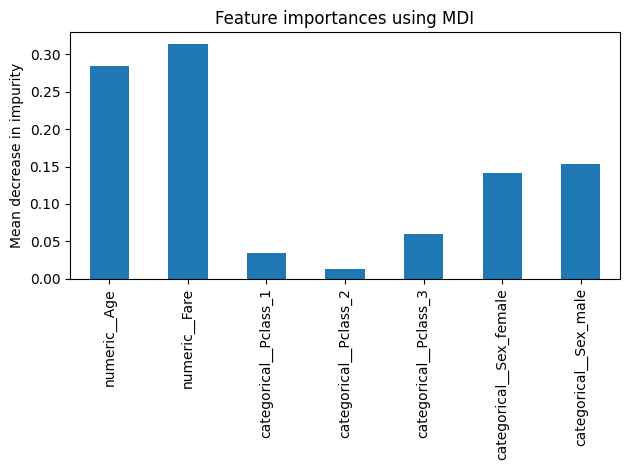

In [33]:
feature_importance(model, feature_transformer.get_feature_names_out())